In [20]:
import datetime
import random
import math
import matplotlib.pyplot as plt
import numpy

from collections import deque

In [21]:
def exponential_random_variable(lambda_value):
    """
    Generates a exponential random variable with lambda input
    """
    random.seed(float(datetime.datetime.now().timestamp()))
    U = random.random()
    x = -(1/lambda_value)*math.log(1-U)
    
    return x

def compute_transmission_delay(L, R):
    return L/R

def compute_propagation_delay(D, S):
  return D/S

In [22]:
class Node:
    def __init__(self, A, T):
        self.queue = deque()
        self.backoff_collision_counter = 0
        self.backoff_busy_counter = 0
        self.max_backoff = 10
        self.override_timestamp = float('-inf')
        self.A = A # average packet arrival rate
        self.T = T # simulation time
        self.completed = False

    def create_queue(self):
        current_time = 0
        # create events up to simulation time T
        while True:
            arrival_time = exponential_random_variable(self.A) + current_time
            if arrival_time > self.T:
                break

            self.queue.append(arrival_time)
            current_time = arrival_time

    def reset_backoff_counters(self):
        self.backoff_collision_counter = 0
        self.backoff_busy_counter = 0

In [28]:
class Lan:
    def __init__(self, N, A, T, CSMACD_type):
        self.N = N # number of nodes
        self.A = A # average packet arrival rate
        self.T = T # simulation time
        self.CSMACD_type = CSMACD_type

        # constants
        self.R = 10**6 # speed of the LAN
        self.L = 1500 # packet length in bits
        self.D = 10 # distance between adjacent nodes on bus
        self.S = (2/3) * (3 * (10**8)) # propagation speed
        self.transmission_delay = compute_transmission_delay(self.L, self.R)
        self.propagation_delay = compute_propagation_delay(self.D, self.S)

        self.dropped_packets = 0
        self.dropped_packets_due_to_busy_medium = 0
        self.completed_nodes = 0
        self.total_transmissions = 0
        self.successful_packet_transmissions = 0
        self.nodes = []
    
    def create_nodes(self):
        for _ in range(self.N):
            node = Node(self.A, self.T)
            node.create_queue()
            self.nodes.append(node)

    def run_simulation(self):
        # check which arrival time is the smallest among the nodes and get node index
        while self.completed_nodes < self.N:
            min_node_index = 0
            min_timestamp = float('inf')
            for i, node in enumerate(self.nodes):
                if node.queue:
                    if node.queue[0] < node.override_timestamp:
                        node.queue[0] = node.override_timestamp
                    if node.queue[0] >= self.T:
                        self.completed_nodes += 1
                        node.queue.clear()
                    else:
                        if node.queue[0] < min_timestamp:
                            min_timestamp = node.queue[0]
                            min_node_index = i

            if self.completed_nodes < self.N:
                # process event at node index
                self.process_sender_node(min_node_index, min_timestamp)
    
    def calculate_exp_backoff_time(self, backoff_counter):
        Tp = 512 / self.R
        return random.randint(0, (2**backoff_counter) - 1) * Tp

    def process_sender_node(self, sender_index, sender_frame_time):
        collision_status = { "collision_detected": False, "max_distance": float('-inf') }
        self.total_transmissions += 1

        # send packet to nodes right of the sender
        self.process_neighbour_node(sender_index, sender_frame_time, collision_status, direction="right")

        # send packet to nodes left of the sender
        self.process_neighbour_node(sender_index, sender_frame_time, collision_status, direction="left")

        sender_node = self.nodes[sender_index]

        if collision_status['collision_detected']:
            sender_node.backoff_collision_counter += 1
            if sender_node.backoff_collision_counter > sender_node.max_backoff:
                # drop packet due to collision
                sender_node.queue.popleft()
                sender_node.reset_backoff_counters()
                sender_node.override_timestamp = sender_frame_time + self.transmission_delay
                self.dropped_packets += 1
            else:
                wait_time = sender_frame_time + self.propagation_delay * collision_status['max_distance'] + self.calculate_exp_backoff_time(sender_node.backoff_collision_counter)
                sender_node.override_timestamp = wait_time
        else:
            sender_node.queue.popleft()
            sender_node.reset_backoff_counters()
            self.successful_packet_transmissions += 1
            transmission_time = sender_frame_time + self.transmission_delay
            sender_node.override_timestamp = transmission_time
            
        if not sender_node.queue:
            self.completed_nodes += 1

    def process_neighbour_node(self, sender_index, sender_frame_time, collision_status, direction):
        curr_index = sender_index
        curr_index = self.get_next_index(curr_index, direction)
        max_distance = collision_status["max_distance"]

        while curr_index >= 0 and curr_index < self.N:
            curr_node = self.nodes[curr_index]
            # if the current node has no more events to offer in its queue, go next
            if not curr_node.queue:
                curr_index = self.get_next_index(curr_index, direction)
                continue
            
            head_frame_time = curr_node.queue[0]
            distance_to_sender = abs(curr_index - sender_index)
            first_bit_received_time = sender_frame_time + (self.propagation_delay * (distance_to_sender))

            # collision occurs
            if head_frame_time <= first_bit_received_time:
                self.total_transmissions += 1
                curr_node.backoff_collision_counter += 1

                if curr_node.backoff_collision_counter > curr_node.max_backoff:
                    # drop packet due to collision
                    curr_node.queue.popleft()
                    curr_node.reset_backoff_counters()
                    curr_node.override_timestamp = head_frame_time + self.transmission_delay
                    self.dropped_packets += 1
                    if not curr_node.queue:
                        self.completed_nodes += 1
                else:
                    wait_time = first_bit_received_time + self.calculate_exp_backoff_time(curr_node.backoff_collision_counter)
                    curr_node.override_timestamp = wait_time
                    
                collision_status["collision_detected"] = True
                collision_status["max_distance"] = max(max_distance, distance_to_sender)

            # no collision but node senses medium as busy
            if head_frame_time > first_bit_received_time and head_frame_time < first_bit_received_time + self.transmission_delay:
                transmission_time = first_bit_received_time + self.transmission_delay
                if self.CSMACD_type == CSMACDType.PERSISTENT:
                    curr_node.override_timestamp = transmission_time
                else:
                    curr_node.backoff_busy_counter += 1
                    wait_time = head_frame_time + self.calculate_exp_backoff_time(curr_node.backoff_busy_counter)
                    # backoff until new wait time is greater than transmission time of last bit of receiving frame
                    while wait_time < transmission_time:
                        curr_node.backoff_busy_counter += 1
                        wait_time = head_frame_time+self.calculate_exp_backoff_time(curr_node.backoff_busy_counter)
                        if curr_node.backoff_busy_counter > curr_node.max_backoff:
                            break
                    if curr_node.backoff_busy_counter > curr_node.max_backoff:
                        # drop packet due to busy backoff counter exceeded
                        curr_node.queue.popleft()
                        curr_node.reset_backoff_counters()
                        curr_node.override_timestamp = head_frame_time + self.transmission_delay
                        self.dropped_packets_due_to_busy_medium += 1
                        if not curr_node.queue:
                            self.completed_nodes += 1
                    else:
                        curr_node.override_timestamp = wait_time

            curr_index = self.get_next_index(curr_index, direction)

    def get_next_index(self, curr_index, direction):
        if direction == "right":
            return curr_index + 1
        elif direction == "left":
            return curr_index - 1

In [24]:
class CSMACDType:
    PERSISTENT, NON_PERSISTENT = range(2)

In [25]:
def plot_efficiency_graphs(Ns, all_efficiencies):
    plt.figure(1, figsize=(16,9))
    As = [7, 10, 20]
    i=0
    for efficiencies in all_efficiencies:
        plt.plot(Ns, efficiencies, label="Arrival rate = {}".format(As[i]))
        plt.title("Efficiency vs. Nodes")
        plt.legend(loc="upper right")
        plt.ylabel('Efficiency of system (successful packets/transmitted packets)')
        plt.xlabel('Number of nodes')
        i += 1
    plt.savefig("efficiencies.pdf", dpi=300)
    plt.show()

In [26]:
def plot_throughput_graphs(Ns, all_throughputs):
    plt.figure(2, figsize=(16,9))
    As = [7, 10, 20]
    i=0
    for throughputs in all_throughputs:
        throughputs = [x / (10**6) for x in throughputs]
        plt.plot(Ns, throughputs, label="Arrival rate = {}".format(As[i]))
        plt.title("Throughput vs. Nodes")
        plt.legend(loc="upper right")
        plt.ylabel('Throughput of system (Mbits/second)')
        plt.xlabel('Number of nodes')
        i += 1
    plt.savefig("throughputs.pdf", dpi=300)
    plt.show()  

In [32]:
T = 1000
Ns = [20, 40, 60, 80, 100]
As = [7, 10, 20]
all_efficiencies_persistent = []
all_throughputs_persistent = []
for A in As:
    efficiencies = []
    throughputs = []
    for N in Ns:
        persisentCSMACD = Lan(N, A, T, CSMACDType.PERSISTENT)
        persisentCSMACD.create_nodes()
        persisentCSMACD.run_simulation()
        efficiencies.append(persisentCSMACD.successful_packet_transmissions/persisentCSMACD.total_transmissions)
        throughputs.append(persisentCSMACD.successful_packet_transmissions*persisentCSMACD.L/T)
    all_efficiencies_persistent.append(efficiencies)
    all_throughputs_persistent.append(throughputs)

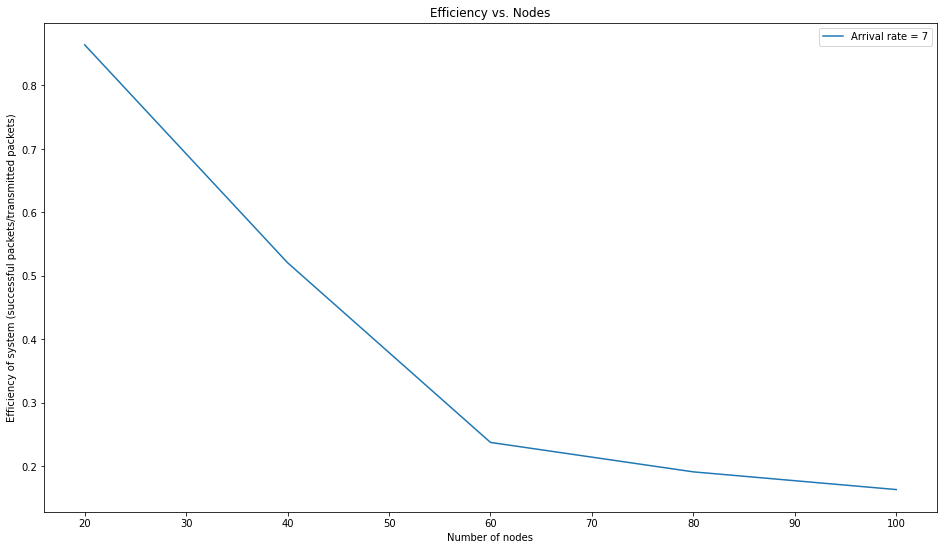

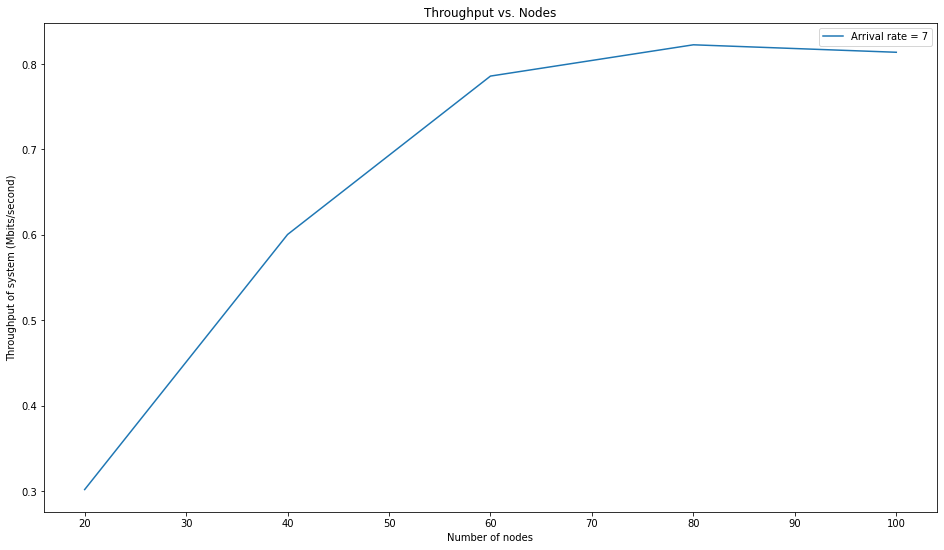

In [33]:
plot_efficiency_graphs(Ns, all_efficiencies_persistent)
plot_throughput_graphs(Ns, all_throughputs_persistent)

In [29]:
T = 1000
Ns = [20, 40, 60, 80, 100]
As = [7, 10, 20]
all_efficiencies_non_persistent = []
all_throughputs_non_persistent = []
for A in As:
    efficiencies = []
    throughputs = []
    for N in Ns:
        nonpersisentCSMACD = Lan(N, A, T, CSMACDType.NON_PERSISTENT)
        nonpersisentCSMACD.create_nodes()
        nonpersisentCSMACD.run_simulation()
        efficiencies.append(nonpersisentCSMACD.successful_packet_transmissions/(nonpersisentCSMACD.total_transmissions+nonpersisentCSMACD.dropped_packets_due_to_busy_medium))
        throughputs.append(nonpersisentCSMACD.successful_packet_transmissions*nonpersisentCSMACD.L/T)
    all_efficiencies_non_persistent.append(efficiencies)
    all_throughputs_non_persistent.append(throughputs)

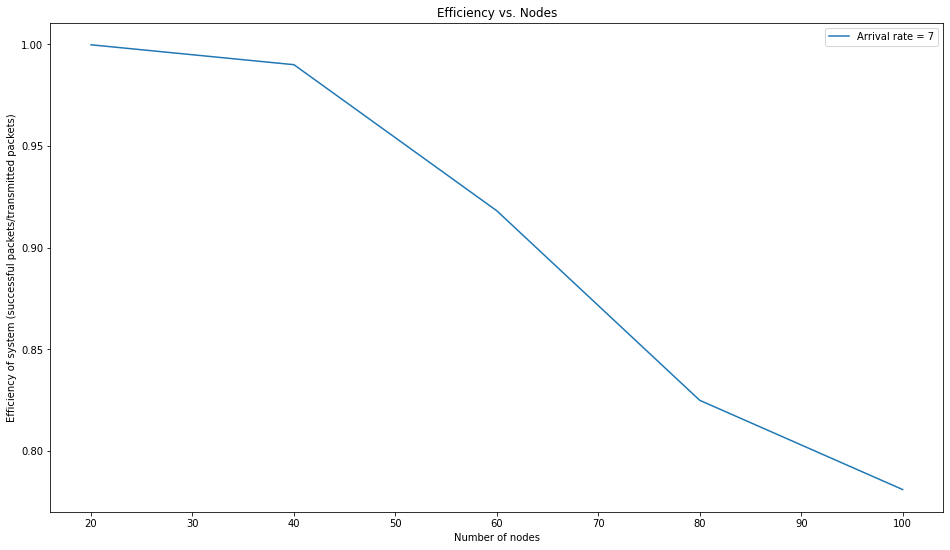

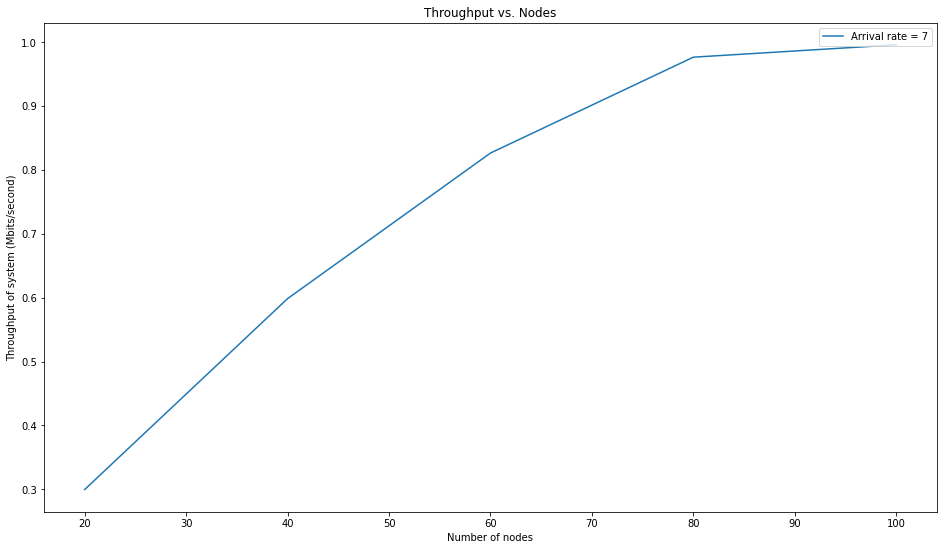

In [30]:
plot_efficiency_graphs(Ns, all_efficiencies_non_persistent)
plot_throughput_graphs(Ns, all_throughputs_non_persistent)

In [ ]:
print(all_efficiencies)
print(all_throughputs)

[[0.9996586482470583, 0.9902814879789482, 0.930903690621927, 0.8515459986654693, 0.7983723200219193]]
[[298710.0, 596094.0, 834948.0, 1018386.0, 1118922.0]]


In [18]:
print(nonpersisentCSMACD.dropped_packets)
print(nonpersisentCSMACD.dropped_packets_due_to_busy_medium)
print(nonpersisentCSMACD.total_transmissions)
total = nonpersisentCSMACD.dropped_packets_due_to_busy_medium + nonpersisentCSMACD.total_transmissions
success = nonpersisentCSMACD.successful_packet_transmissions
print(success/total)
print(success * nonpersisentCSMACD.L)
print(nonpersisentCSMACD.N)

0
46514
165890
0.7809551609197567
248817000
100
